# Efficiency fitting for semiconductor detectors
---
---

### Initial setup
---
Import packages

In [1]:
# General functionalities
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt

# uncertainty utility
import uncertainties
from uncertainties import ufloat as uf
from uncertainties import unumpy as unp

# Custom utility
from __plotUtility__ import *
from __fitUtility__ import *
from __traceUtility__ import *

Load in data

In [5]:
# File headers: Source, A, A_err E E_err I I_err C C_err time
# Units: energies in keV; times in s; counts in absolute; mean and std in uncalibrated channels
Sources = ['56Co', '137Cs', '133Ba', '152Eu']
keys = ['source', 'A', 'A_err', 'E', 'E_err', 'I', 'I_err', 'C', 'C_err', 't']
dictData = {}

directory = "data/"

for source in Sources:
    dictData[source] = pd.read_csv(directory + "Fitresults_" + source + ".txt", header=0, names=keys, sep = ' ')

In [6]:
# Source : [activity, activity relative uncertainty] in Bq
activities = {
    '56Co'  : uf(dictData['56Co']['A'][0], dictData['56Co']['A_err'][0]),
    '133Ba' : uf(dictData['133Ba']['A'][0], dictData['133Ba']['A_err'][0]),
    '152Eu' : uf(dictData['152Eu']['A'][0], dictData['152Eu']['A_err'][0]),
    '137Cs' : uf(dictData['137Cs']['A'][0], dictData['137Cs']['A_err'][0])
}

# Plot points from a different source with different markers and colors
markers = {
    '56Co'  : 'o',
    '133Ba' : 'v',
    '152Eu' : '*',
    '137Cs' : 'x'
}

markersizes = {
    '56Co'  : 6,
    '133Ba' : 8,
    '152Eu' : 8,
    '137Cs' : 8
}

colors = {
    '56Co'  : 'tab:blue',
    '133Ba' : 'tab:orange',
    '152Eu' : 'tab:green',
    '137Cs' : 'tab:pink'
}

plotSettings = {
    'markers'     : markers,
    'markersizes' : markersizes,
    'colors'      : colors
}

Concat data

In [7]:
# Scale counts to time, intensity, and activity (efficiency in ratio of 1)
columns = ['E', 'E_err', 'C', 'C_err', 'A', 'A_err', 'Intensity', 't', 'source']
data = pd.DataFrame(columns = columns)

for source in Sources:
    # Error propagation log(x) --> d(log(x)) = dx/x (assuming relative error is < 10% or so)
    dictData[source]['logC']     = np.log(dictData[source]['C'])
    dictData[source]['logC_err'] = dictData[source]['C_err']/dictData[source]['C']
    
    for index in range(len(dictData[source])):
        entry = {
            'E'        : dictData[source]['E'][index],
            'E_err'    : dictData[source]['E_err'][index],
            'C'        : dictData[source]['C'][index],
            'C_err'    : dictData[source]['C_err'][index],
            'logC'     : dictData[source]['logC'][index],
            'logC_err' : dictData[source]['logC_err'][index],

            'A'        : activities[source].n,
            'A_err'    : activities[source].s,
            'Intensity': dictData[source]['I'][index],
            't'        : dictData[source]['t'][index],
            'source'   : source
        }

        # Supresses warning of concating empty dataframe
        if (len(data) == 0):
            data = pd.DataFrame(entry, columns = columns, index=[0])
        else:
            data = pd.concat([data, pd.DataFrame([entry], columns=data.columns)], ignore_index=True)

Calculate efficiency and log efficiency

In [8]:
data['eff']         = data['C'] / (data['t'] * data['Intensity'] * data['A'])
data['logeff']      = np.log(data['eff'])
data['eff_staterr'] = data['eff'] * (data['C_err']/data['C'])
data['eff_syserr']  = data['eff'] * (activities[source].s/activities[source].n)
data['eff_err']     = np.sqrt(data['eff_staterr']**2 + data['eff_syserr']**2)
data['logeff_err']  = data['eff_err']/data['eff']

Initial plot of the data

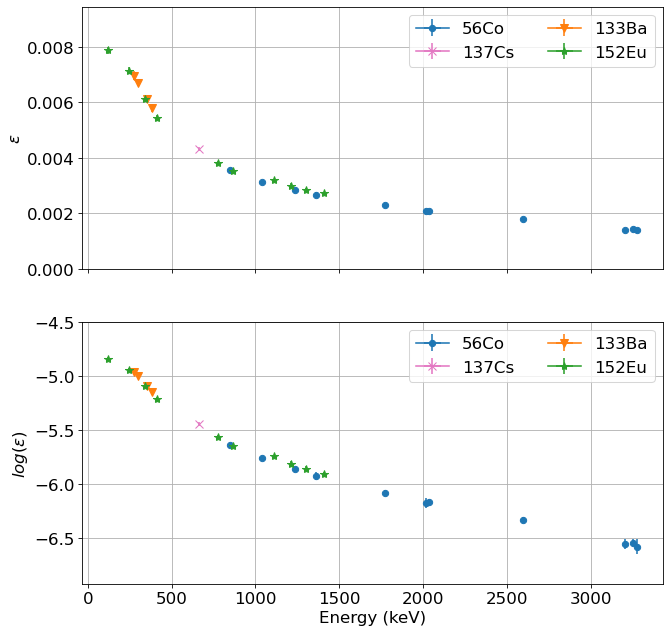

In [9]:
fitDict = {'show': False, 'xvals': 0, 'yvals': 0, 'lower': 0, 'upper': 0}

fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
plot_eff(ax[0], data, fitDict, plotSettings, legendCol=2)
plot_logEff(ax[1], data, fitDict, plotSettings, legendCol=2)
ax[0].set_xlabel("")
plt.show()

### Fitting procedure
---

In [10]:
# Fit and plot options
order      = 4
scaling    = 500
nLinspace  = 100
E_linspace = np.linspace(100, 3350, nLinspace)

Standard least square approach

Best used for rough estimates and determining optimal scaling energies

In [11]:
model = sm_logmodel(order, scaling=scaling)
smFit = sm.WLS.from_formula(formula=model, data=data, weights=(data['logeff_err'])**(-2)).fit()
smPrediction = sm_predict(E_linspace, smFit, scaling=scaling, uncertainty=True) # Returns: mean, mean-error, mean+error

In [12]:
print("------------------------------")
print(f'Scaling = {scaling:d}')
print(f'R2 = {smFit.rsquared:.4f}')
print(f'Condition number = {smFit.condition_number:.2f}') # Lower = generally better

corrMatrix = sm_help.cov2corr(smFit.cov_params())
print(f'Minimal Correlation = {np.min(np.abs(corrMatrix)):.3f}')
np.fill_diagonal(corrMatrix, 0)
print(f'Maximal Correlation = {np.max(np.abs(corrMatrix)):.3f}')
print("------------------------------")

------------------------------
Scaling = 500
R2 = 0.9984
Condition number = 18.86
Minimal Correlation = 0.292
Maximal Correlation = 0.952
------------------------------


Bayesian approach

Be patient: First it calculates a bit, then it does some initial sampling without progresing, then it samples for a few minutes

In [13]:
# Fit function definition
order   = 4   # Max exponent of log(E) in the model
scaling = 500 # Scaling energy (best to take something rather central in the data set)


# Sampling options
newTrace  = False  # Sample new trace or use existing --> Set to false once happy with the trace to save runtime
beta      = 2     # Inverse spread of the activity uncertainty (hyperprior)
nCores    = 8     # Number of cores used in the MC sampling
nChains   = 4     # Number of chains made in the MC sampling
nSteps    = 10000 # Number of steps per chain in the MC sampling
nameTrace = f'exampleFit_order4'

print("------------------------------")
trace = bayesian_fit(data, dictData, activities, Sources, 
                     nameTrace, newTrace=newTrace, 
                     order=order, scaling=scaling, beta=beta,
                     nCores=nCores, nChains=nChains, nSteps=nSteps)
print("------------------------------")

------------------------------
------------------------------


### Fit diagnostics
---
Check if traces look fine

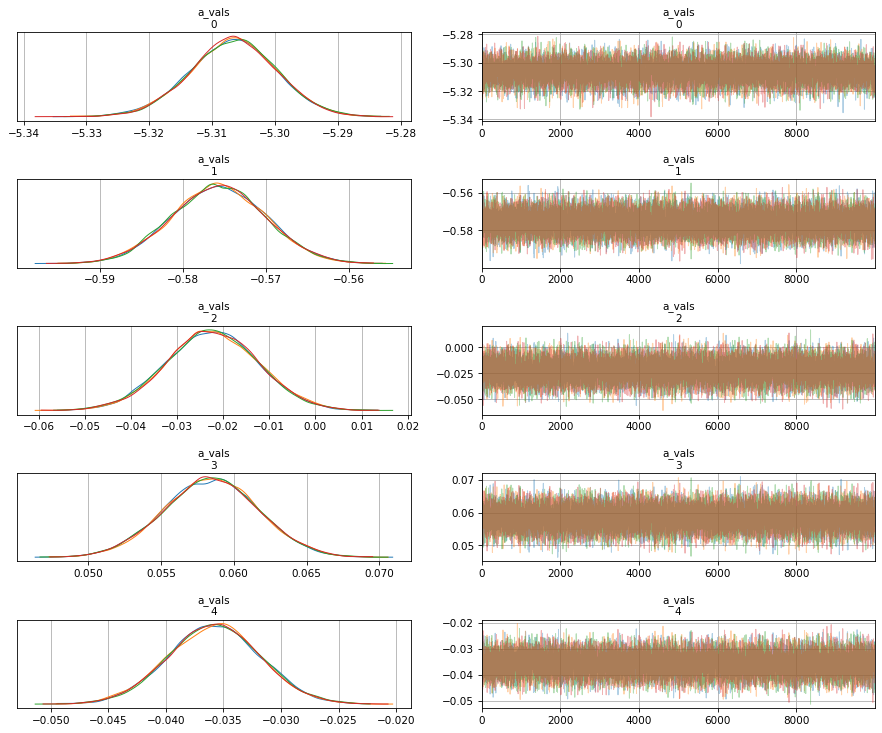

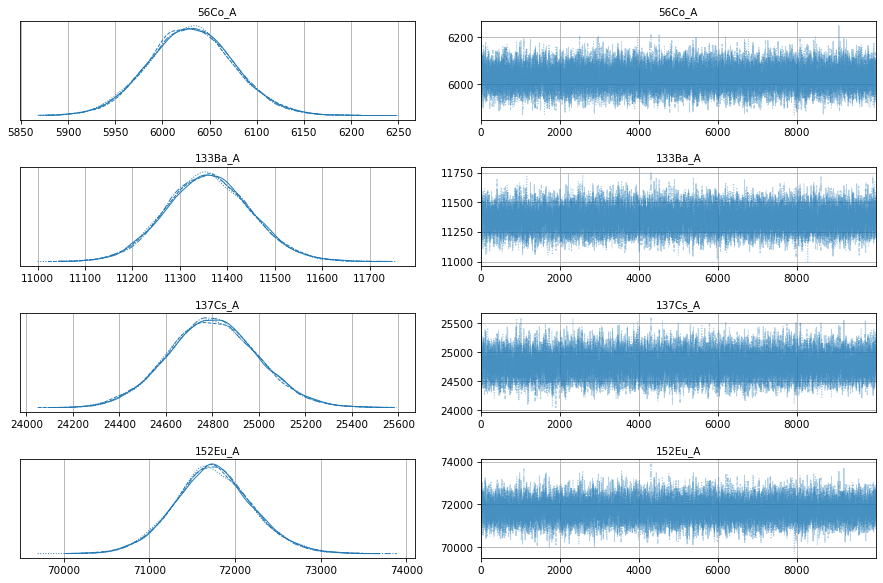

In [14]:
ax = az.plot_trace(trace, var_names=['a_vals'], compact=False)
plt.tight_layout()
plt.show()

ax = az.plot_trace(trace, var_names=['56Co_A', '133Ba_A', '137Cs_A', '152Eu_A'])
plt.tight_layout()
plt.show()

Draw a cornerplot of results

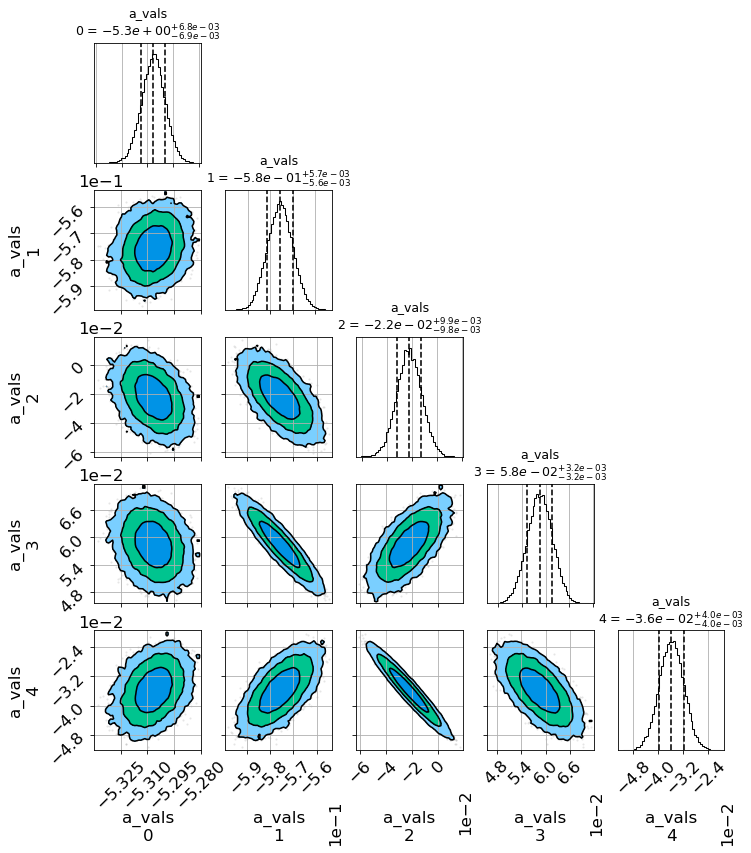

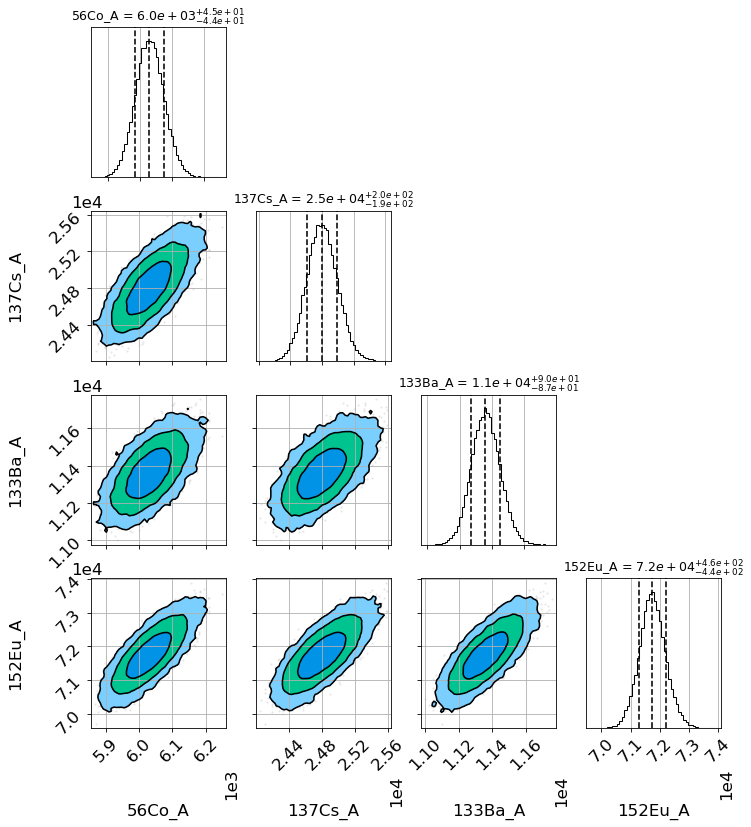

In [15]:
corner_plot(trace, ['a_vals'], 5)
corner_plot(trace, ['56Co_A', '137Cs_A', '133Ba_A', '152Eu_A'], 4)

### Plotting the results
---
Results from statsmodels

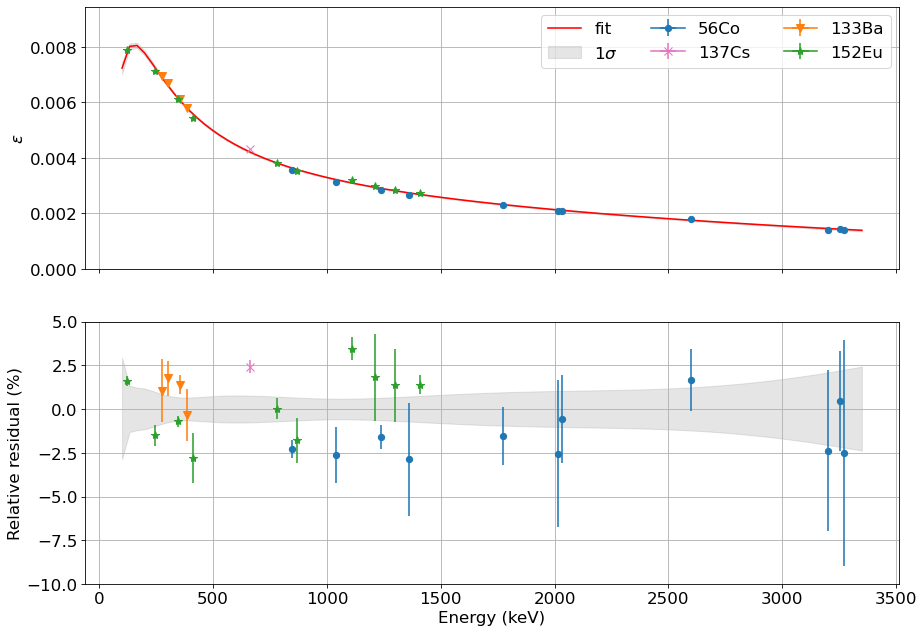

In [16]:
fig, ax = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

fitDict = {'show': True, 'xvals': E_linspace, 'yvals': np.exp(smPrediction[0]), 
           'lower': np.exp(smPrediction[1]), 'upper': np.exp(smPrediction[2])}

temp_data = copy.deepcopy(data)
temp_data['eff_err'] = data['eff'] * (data['C_err']/data['C'])

plot_eff(ax[0], temp_data, fitDict, plotSettings)
plot_relResid_eff(ax[1], temp_data, fitDict, plotSettings, legendLoc="upper left")

ax[0].set_xlabel("")
ax[1].set_ylim([-10, 5])
plt.show()

Now for the Bayesian fit:

Extract median and +-1 sigma limits

In [18]:
bayesianMedian, bayesianConfNeg, bayesianConfPos = trace_to_predict(trace, E_linspace, order=order, scaling=scaling)
bayesianA = trace_to_activity(trace, Sources)

Show ratio between activity predicted by the fit and used as input

In [19]:
A_ratio = {}

for source in Sources:
    A_ratio[source] = bayesianA[source][0]/activities[source].n
    error = bayesianA[source][1]/activities[source].n
    
    print(f'Activity ratio {source}: {A_ratio[source]:.3f} +/- {error:.3f}')

Activity ratio 56Co: 0.970 +/- 0.007
Activity ratio 137Cs: 1.022 +/- 0.008
Activity ratio 133Ba: 1.022 +/- 0.008
Activity ratio 152Eu: 1.001 +/- 0.006


Get recalculated efficiencies based on activities from fit

In [20]:
data['recalc_eff']     = np.zeros(len(data))
data['recalc_eff_err'] = np.zeros(len(data))

# Shift the efficiencies according to the ratio of the quoted and new activities
for index in range(len(data)):
    data.loc[index, 'recalc_eff']     = data['eff'][index] / A_ratio[data['source'][index]]
    data.loc[index, 'recalc_eff_err'] = data['eff_staterr'][index] / A_ratio[data['source'][index]]

Plot efficiency with relative residuals

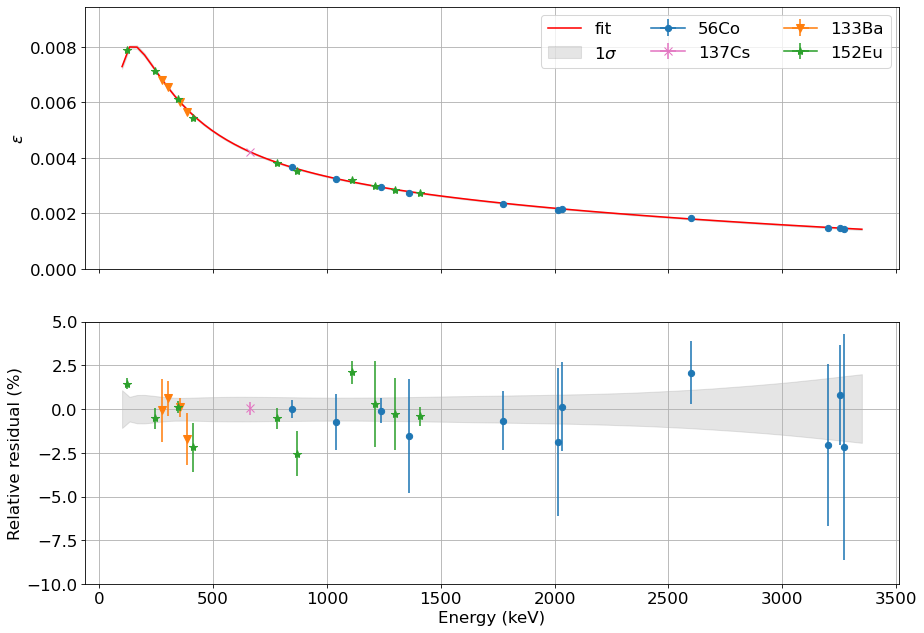

In [21]:
fig, ax = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

fitDict = {'show': True, 'xvals': E_linspace, 'yvals': bayesianMedian, 
           'lower': bayesianConfNeg, 'upper': bayesianConfPos}
plot_eff(ax[0], data, fitDict, plotSettings, scaled=True)
plot_relResid_eff(ax[1], data, fitDict, plotSettings, legendLoc="upper left", scaled=True)

ax[0].set_xlabel("")
ax[1].set_ylim([-10, 5])
plt.show()

### Relative efficiencies
---

In [22]:
nameTrace = f'exampleFit_order4'
refEnergy  = 1000
nLinspace  = 100
E_linspace = np.linspace(100, 3350, nLinspace)

RelEffMedian, RelEffConfNeg, RelEffConfPos, refEff = bayes_relative_efficiency(E_linspace, refEnergy, nameTrace, scaling=scaling)

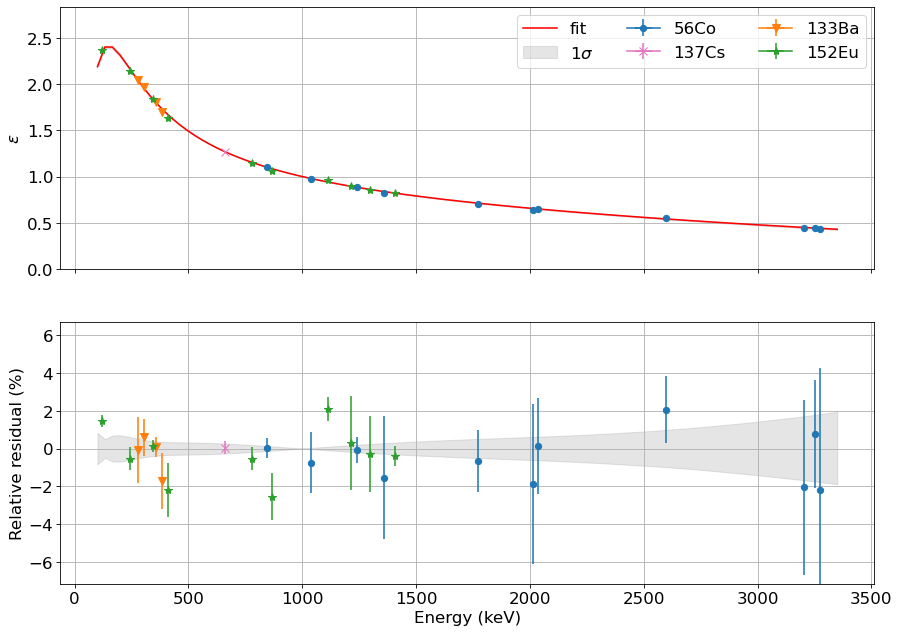

In [23]:
scaledData = copy.copy(data)
scaledData['eff']            = data['eff'] / refEff
scaledData['eff_err']        = data['eff_err'] / refEff
scaledData['recalc_eff']     = data['recalc_eff'] / refEff
scaledData['recalc_eff_err'] = data['recalc_eff_err'] / refEff


fig, ax = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

fitDict = {'show': True, 'xvals': E_linspace, 'yvals': RelEffMedian, 
           'lower': RelEffConfNeg, 'upper': RelEffConfPos}

plot_eff(ax[0], scaledData, fitDict, plotSettings, scaled=True)
plot_relResid_eff(ax[1], scaledData, fitDict, plotSettings, legendLoc="upper left", scaled=True)

ax[0].set_xlabel("")
plt.show()

### Calculate efficiency at a given energy
---

In [24]:
E_line = 2500
eff_median, eff_lower, eff_upper = trace_to_efficiency(trace, E_line, order=order, scaling=scaling)
eff_error = 0.5 * ((eff_median - eff_lower) + (eff_upper - eff_median))

eff_line = uf(eff_median, eff_error)

print(f'Efficiency at {E_line} keV = {eff_line:.3e}')

Efficiency at 2500 keV = (1.859+/-0.019)e-03
